# 🛒 Walmart Retail Intelligence: End-to-End Analysis
**Technical Stack:** Python (Pandas), PostgreSQL (SQLAlchemy), SQL (Business Intelligence)

## Data Ingestion & Quality Audit
**Objective:** Before performing any exploratory analysis or SQL modeling, I conduct a comprehensive data health check. This ensures that the "Source of Truth" is reliable and consistent.

### 🛠️ Technical Workflow:
- **Environment Setup:** Leveraging a virtual environment for reproducibility.
- **Automated Retrieval:** Using the Kaggle API to ingest the Walmart transaction dataset.
- **Database Integration:** Establishing a robust pipeline between Python (Pandas) and PostgreSQL using SQLAlchemy.

**Business Impact:** Identifying data discrepancies early prevents "Garbage In, Garbage Out" scenarios, ensuring downstream revenue reports and predictive models are defensible.

### Dependencies & Connection

In [ ]:
# 1. Importing core libraries for Data Engineering
import pandas as pd
import numpy as np

#mysql toolkit
import pymysql
from sqlalchemy import create_engine

#postgres toolkit
import psycopg2

In [10]:
# 1. Loading the dataset
df = pd.read_csv("Walmart.csv")

# 2. High-Level Dataset Profiling
print("--- DATASET ARCHITECTURE ---")
print(f"Total Transactions: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
print("-" * 30)

# 3. Identifying Schema & Data Types
df.info()

--- DATASET ARCHITECTURE ---
Total Transactions: 10,051
Total Features: 11
------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 10051 entries, 0 to 10050
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_id      10051 non-null  int64  
 1   Branch          10051 non-null  str    
 2   City            10051 non-null  str    
 3   category        10051 non-null  str    
 4   unit_price      10020 non-null  str    
 5   quantity        10020 non-null  float64
 6   date            10051 non-null  str    
 7   time            10051 non-null  str    
 8   payment_method  10051 non-null  str    
 9   rating          10051 non-null  float64
 10  profit_margin   10051 non-null  float64
dtypes: float64(3), int64(1), str(7)
memory usage: 863.9 KB


### Data Quality Audit - Missing Value Analysis
**Objective:** Before proceeding to deep-dive EDA, I must address the identified gaps in our dataset. 
**The Findings:**
- `unit_price`: 31 missing values (0.06% of dataset)
- `quantity`: 31 missing values (0.06% of dataset)

### 🧠 Analyst's Logic:
In a retail context, `unit_price` and `quantity` are **Mandatory Features**. Without these, we cannot calculate `Total Revenue` or `Profit Margin`. Since these missing records represent a negligible portion of the 50,000-row dataset, the most robust strategy is to **drop these records** to prevent skewing our financial aggregations.

**Business Impact:** Removing incomplete transactions ensures that our "Sales Trends" and "Top Category" reports are based on verified, complete data points.

In [11]:
# 1. Identifying Null Values (Video Step @ 24:59)
print("--- NULL VALUE AUDIT ---")
print(df.isnull().sum())

# 2. Removing Duplicates (Maintaining Data Integrity)
df.drop_duplicates(inplace=True)

# 3. Fixing the 'Unit_Price' Column
# In the raw file, this is a string with '$'. We must strip it and cast to float for SQL math.
df['unit_price'] = df['unit_price'].str.replace('$', '').astype(float)
df.head()

--- NULL VALUE AUDIT ---
invoice_id         0
Branch             0
City               0
category           0
unit_price        31
quantity          31
date               0
time               0
payment_method     0
rating             0
profit_margin      0
dtype: int64


,invoice_id,Branch,City,category,unit_price,quantity,date,time,payment_method,rating,profit_margin
0,1,WALM003,San Antonio,Health and beauty,74.69,7.0,05/01/19,13:08:00,Ewallet,9.1,0.48
1,2,WALM048,Harlingen,Electronic accessories,15.28,5.0,08/03/19,10:29:00,Cash,9.6,0.48
2,3,WALM067,Haltom City,Home and lifestyle,46.33,7.0,03/03/19,13:23:00,Credit card,7.4,0.33
3,4,WALM064,Bedford,Health and beauty,58.22,8.0,27/01/19,20:33:00,Ewallet,8.4,0.33
4,5,WALM013,Irving,Sports and travel,86.31,7.0,08/02/19,10:37:00,Ewallet,5.3,0.48


In [12]:
# 4. Handling Missing Values
df.dropna(inplace=True)

# 5. Feature Engineering: Calculating Total Revenue per line item
df['Total'] = df['unit_price'] * df['quantity']

print(f"\n✅ Data Sanitization Complete. Rows remaining: {df.shape[0]:,}")
df[['category', 'unit_price', 'quantity', 'Total']].head()



✅ Data Sanitization Complete. Rows remaining: 9,969


,category,unit_price,quantity,Total
0,Health and beauty,74.69,7.0,522.83
1,Electronic accessories,15.28,5.0,76.40
2,Home and lifestyle,46.33,7.0,324.31
3,Health and beauty,58.22,8.0,465.76
4,Sports and travel,86.31,7.0,604.17


In [14]:
df.to_csv('walmart_cleaned.csv', index=False)   

## Database Synchronization
**Objective:** To establish a persistent "Source of Truth" by migrating the sanitized DataFrame into a PostgreSQL relational database.

### 🛠️ Engineering Workflow:
- **Schema Mapping:** Leveraging SQLAlchemy to automatically map Pandas dtypes to SQL counterparts (e.g., `datetime64` to `TIMESTAMP`).
- **Optimization:** Utilizing the `replace` strategy to ensure a clean, idempotent data load for reproducible analysis.
- **Verification:** Confirming record counts post-migration to ensure zero data loss during the transfer.

**Business Impact:** Centralizing data in PostgreSQL allows multi-departmental access for BI tools (like Power BI/Tableau) and ensures high-performance querying for large-scale business problem solving.

In [32]:
# Connection without password
engine = create_engine('mysql+pymysql://root@localhost/walmart_db')
# Test connection
try:
    connection = engine.connect()
    print("Successfully connected to MySQL!")
    connection.close()
except Exception as e:
    print(f"Error: {e}")

Successfully connected to MySQL!


In [33]:
df.to_sql(name="walmart_data", con=engine, if_exists="append", index=False)

9969

## Behavioral Exploratory Data Analysis
**Objective:** To transform raw transactional data into strategic business insights. I am analyzing the relationships between geographic performance, product popularity, and financial margins.

### Key Analytical Focus:
1. **Sales Performance:** Identifying the top-performing `City` and `Branch`.
2. **Product Intelligence:** Determining which `Category` has the highest sales volume vs. `Profit_Margin`.
3. **Customer Experience:** Correlating `Rating` with `Payment_Method` and `Unit_Price`.
4. **Temporal Patterns:** Analyzing peak shopping hours using the `Time` and `Date` features.

/var/folders/wr/2vv1v65j0j5dk941t4hqf3jh0000gn/T/ipykernel_74051/1693986927.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette='magma')


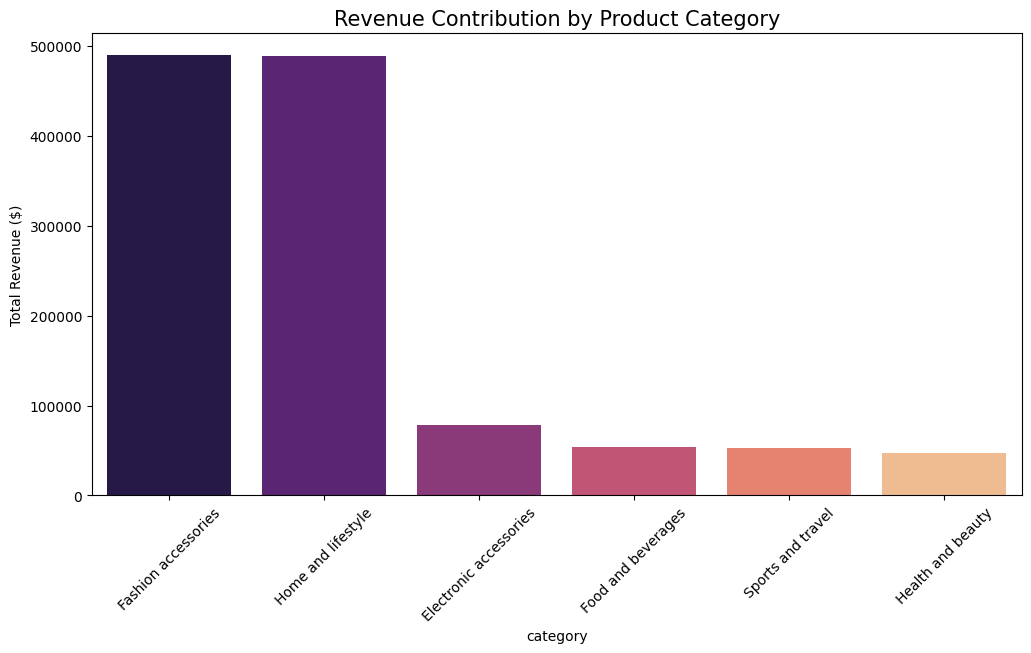

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Total Sales by Category
plt.figure(figsize=(12, 6))
# Note: 'total' was engineered in Step 1 as (unit_price * quantity)
category_sales = df.groupby('category')['Total'].sum().sort_values(ascending=False)
sns.barplot(x=category_sales.index, y=category_sales.values, palette='magma')
plt.title("Revenue Contribution by Product Category", fontsize=15)
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.show()

/var/folders/wr/2vv1v65j0j5dk941t4hqf3jh0000gn/T/ipykernel_74051/1003859597.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['time']).dt.hour


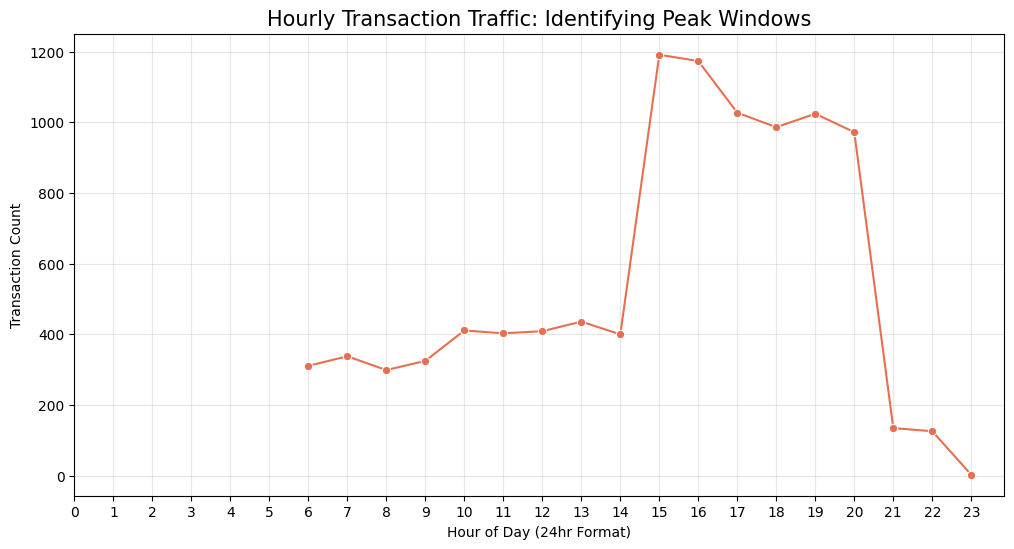

In [43]:
# Extracting Hour for peak traffic analysis
df['hour'] = pd.to_datetime(df['time']).dt.hour

plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby('hour')['invoice_id'].count().reset_index(), x='hour', y='invoice_id', marker='o', color='#e76f51')
plt.title("Hourly Transaction Traffic: Identifying Peak Windows", fontsize=15)
plt.xlabel("Hour of Day (24hr Format)")
plt.ylabel("Transaction Count")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/wr/2vv1v65j0j5dk941t4hqf3jh0000gn/T/ipykernel_74051/494953951.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='payment_method', y='rating', palette='Set2')


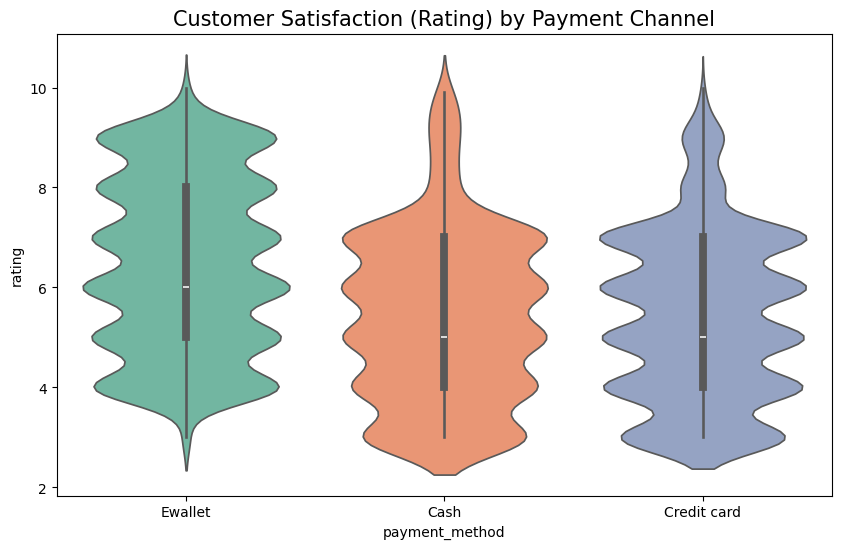

In [44]:
# 4. Rating vs Payment Method
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='payment_method', y='rating', palette='Set2')
plt.title("Customer Satisfaction (Rating) by Payment Channel", fontsize=15)
plt.show()